### Here I show how I obtained certain parameter values and some ideas for improving the estimates.  

In [1]:
# Autoreload all modules when changes are saved. 
%reload_ext autoreload
%autoreload 2  

# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import olf_pred

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from olf_pred.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from olf_pred.gerkin import dream,fit1,fit2

In [3]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [4]:
# Figure out parameters for regularization.  
regs = np.linspace(0,1,11)
matrix_training = np.zeros((len(regs),9))
matrix_leaderboard = np.zeros((len(regs),9))
for i,reg in enumerate(regs):
    result = fit1.subject_regularize(rfcs,X_training,X_training,Y_training,oob=True,regularize=[reg])
    matrix_training[i,:] = result
    result = fit1.subject_regularize(rfcs,X_leaderboard_int,X_leaderboard_other,Y_leaderboard,oob=False,regularize=[reg])
    matrix_leaderboard[i,:] = result

for matrix in (matrix_training,matrix_leaderboard):
    plt.figure()
    matrix /= matrix.max(axis=0)[np.newaxis,:]
    plt.pcolor(matrix[:,3],vmin=0.8,vmax=1)

NameError: name 'rfcs' is not defined

In [ ]:
# Determine Lasso performance.  
alphas = np.logspace(-2,1,8)
lassos1 = {}
scores1_train = []
scores1_test = []
scores2_train = []
scores2_test = []
for alpha in alphas:
    print(alpha)
    lassos,score_train,score_test = lasso_(X_training,Y_training_median['subject'],
                                          X_leaderboard_int,Y_leaderboard['subject'],
                                          1,alpha=alpha,regularize=[0.3,0.3,0.3])
    scores1_train.append(score_train[0])
    scores1_test.append(score_test[0])
    scores2_train.append(score_train[1])
    scores2_test.append(score_test[1])
    lassos1[alpha] = lassos

plt.scatter(alphas,scores1_train,color='b')
plt.scatter(alphas,scores1_test,color='r')
plt.xscale('log')

plt.figure()
plt.scatter(alphas,scores2_train,color='b')
plt.scatter(alphas,scores2_test,color='r')
plt.xscale('log')

In [ ]:
estimator1 = Lasso(alpha=0.9,max_iter=5000)
estimator2 = Lasso(alpha=0.9,max_iter=5000)
estimator1.fit(X_obs,Y_obs['mean_std'][:,1])
x = estimator1.coef_
estimator2.fit(X_leaderboard,Y_leaderboard['mean_std'][:,1])
y = estimator2.coef_
plt.scatter(x,y)
plt.figure()
plt.plot(x,color='r')
plt.plot(y,color='b')
np.where(x*y > 0.01)

In [ ]:
# Determine Lasso performance.  
alphas = np.logspace(-2,1,8)
lassos1 = {}
scores1_train = []
scores1_test = []
scores2_train = []
scores2_test = []
for alpha in alphas:
    print(alpha)
    lassos,score_train,score_test = lasso_(X_training,Y_training_median['mean_std'],
                                          X_leaderboard_int,Y_leaderboard['mean_std'],
                                          2,alpha=alpha)
    scores1_train.append(score_train[0])
    scores1_test.append(score_test[0])
    scores2_train.append(score_train[1])
    scores2_test.append(score_test[1])
    lassos1[alpha] = lassos

plt.scatter(alphas,scores1_train,color='b')
plt.scatter(alphas,scores1_test,color='r')
plt.xscale('log')

plt.figure()
plt.scatter(alphas,scores2_train,color='b')
plt.scatter(alphas,scores2_test,color='r')
plt.xscale('log')

In [ ]:
estimator1 = Lasso(alpha=0.9,max_iter=5000)
estimator2 = Lasso(alpha=0.9,max_iter=5000)
estimator1.fit(X_obs,Y_obs['mean_std'][:,1])
x = estimator1.coef_
estimator2.fit(X_leaderboard,Y_leaderboard['mean_std'][:,1])
y = estimator2.coef_
plt.scatter(x,y)
plt.figure()
plt.plot(x,color='r')
plt.plot(y,color='b')
np.where(x*y > 0.01)

In [ ]:
# Minimum samples per leaf.  
ns = [1,2,4,8,16,32]
rs = {n:fit2.rfc_cv(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],n_splits=15,n_estimators=25,min_samples_leaf=n) for n in ns}
for kind1 in ['int','ple','dec']:
    for kind2 in ['mean','sigma','trans']:
        n_ = sorted(list(rs.keys()))[0]
        if kind2 in rs[n_][1][kind1]:
            means = [rs[n][1][kind1][kind2]['mean'] for n in ns]
            sems = [rs[n][1][kind1][kind2]['sem'] for n in ns]
            plt.errorbar(ns,means,sems,label=kind1+'_'+kind2)
            plt.xscale('log')
            plt.xlim(0.5,1000)
            plt.xlabel('min_samples_leaf')
            plt.ylabel('r')
            plt.legend()

In [ ]:
# Maximum tree depth.  
ns = (2**np.linspace(1,5,9)).astype('int')
rs = {n:rfc_cv(X_all,Y_all['mean_std'],n_splits=25,max_depth=n) for n in ns}
for kind1 in ['int','ple','dec']:
    for kind2 in ['mean','sigma','trans']:
        if kind2 in rs[2.0][1][kind1]:
            means = [rs[n][1][kind1][kind2]['mean'] for n in ns]
            sems = [rs[n][1][kind1][kind2]['sem'] for n in ns]
            plt.errorbar(ns,means,sems,label=kind1+'_'+kind2)
            plt.xscale('log')
            plt.xlabel('Max Depth')
            plt.xlim(1,1000)
            plt.legend()

In [ ]:
Y_training_mask,_ = dream.make_Y_obs(['training'],imputer='mask')
Y_training_median,_ = dream.make_Y_obs(['training'],imputer='median')
Y_training_zero,_ = dream.make_Y_obs(['training'],imputer='zero')

In [ ]:
y = Y_training_mask
y_mean = y['mean_std'][:,:21]/100.0
y_std = y['mean_std'][:,21:]/100.0

In [ ]:
from scipy.optimize import curve_fit
x = y_mean[:,0]
y = y_std[:,0]
def f(x,k0,k1):
    return k0*x**(k1*0.5) - k0*x**(k1*2)
k0,k1=curve_fit(f,x,y,p0=[0.7,1],maxfev=10000)[0]
print("k0=%.3g; k1=%.3g" % (k0,k1))
plt.scatter(x,y,label='Data')
x_ = np.linspace(0,1.0,100)
plt.plot(x_,f(x_,k0,k1),color='r',linewidth=3,label='Fit')
plt.xlabel('Intensity Mean')
plt.ylabel('Intensity StDev')
plt.legend()
plt.figure()
plt.scatter(x,y-f(x,k0,k1))
def f_int(x):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))

#print('r using fit itself = %.3g' % scoring.r2(None,None,rfcs[2][0][3].oob_prediction_[:,21],Y_training['mean_std'][:,21]))
#print('r using f_int = %.3g' % scoring.r2(None,None,f_int(rfcs[2][0][0].oob_prediction_[:,0]),Y_training['mean_std'][:,21]))
#print('r using f_int = %.3g' % scoring.r2(None,None,rfcs[2][0][0].oob_prediction_[:,0],Y_training['mean_std'][:,0]))

In [ ]:
from scipy.optimize import curve_fit
x = y_mean[:,1]
y = y_std[:,1]
def f(x,k0,k1):
    return k0*x**(k1*0.5) - k0*x**(k1*2)
k0,k1=curve_fit(f,x,y,p0=[0.7,1])[0]
print(k0,k1)
plt.scatter(x,y,label='Data')
x_ = np.linspace(0,1.0,100)
plt.plot(x_,f(x_,k0,k1),color='r',linewidth=3,label='Fit')
plt.xlabel('Pleasantness Mean')
plt.ylabel('Pleasantness StDev')
plt.legend()
plt.legend()
plt.figure()
plt.scatter(x,y-f(x,k0,k1))
def f_ple(x):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))

In [ ]:
from scipy.optimize import curve_fit
x = y_mean[:,2:21].ravel()
y = y_std[:,2:21].ravel()
def f(x,k0,k1):
    return k0*x**(k1*0.5) - k0*x**(k1*2)
k0,k1=curve_fit(f,x,y,p0=[0.7,1])[0]
print(k0,k1)
plt.scatter(x,y,label='Data')#Y_obs['mean_std'][:,0],Y_obs['mean_std'][:,21])
x_ = np.linspace(0,1.0,100)
plt.plot(x_,f(x_,k0,k1),color='r',linewidth=3,label='Fit')
plt.xlabel('Other Descriptors Mean')
plt.ylabel('Other Descriptors StDev')
plt.legend()
plt.legend()
plt.figure()
plt.scatter(x,y-f(x,k0,k1))
def f_dec(x):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))

In [ ]:
# Plot r vs the maximum number of features per tree for subchallenge 2.  
ns = np.logspace(1,3.48,12).astype('int')
rs = {10: ({'mean': 4.5287503680444283, 'sem': 0.13714615321987517},
  {'dec': {'mean': {'mean': 0.35741904017752996, 'sem': 0.010048318402360087},
    'sigma': {'mean': 0.26364038011571522, 'sem': 0.0066697475868345195}},
   'int': {'mean': {'mean': 0.095846326633119261, 'sem': 0.011534906168037609},
    'sigma': {'mean': -0.19442773962706283, 'sem': 0.013246295480355922},
    'trans': {'mean': -0.14841245979725629, 'sem': 0.014477101914558255}},
   'ple': {'mean': {'mean': 0.56265800877494421, 'sem': 0.013762511615746981},
    'sigma': {'mean': 0.078114653930579078, 'sem': 0.013059909526612193}}}),
 16: ({'mean': 4.2762653281962626, 'sem': 0.14630142507898916},
  {'dec': {'mean': {'mean': 0.33607958258692089, 'sem': 0.010755178194062617},
    'sigma': {'mean': 0.24953806713067767, 'sem': 0.0072430177045214993}},
   'int': {'mean': {'mean': 0.080597860297553225, 'sem': 0.010328564454501418},
    'sigma': {'mean': -0.1831432623519923, 'sem': 0.015823665199024079},
    'trans': {'mean': -0.1339838955094253, 'sem': 0.016009654970459093}},
   'ple': {'mean': {'mean': 0.53454801842938016, 'sem': 0.013648074163107654},
    'sigma': {'mean': 0.083599248367205059, 'sem': 0.010150692008152835}}}),
 28: ({'mean': 4.4701678025412317, 'sem': 0.14599522051390151},
  {'dec': {'mean': {'mean': 0.34870707634403841, 'sem': 0.010376725741241408},
    'sigma': {'mean': 0.26167957616840015, 'sem': 0.0076003340767839701}},
   'int': {'mean': {'mean': 0.10319739802052659, 'sem': 0.014246267245439325},
    'sigma': {'mean': -0.19009823259725972, 'sem': 0.011209139395029032},
    'trans': {'mean': -0.11650510017477485, 'sem': 0.012928859605985615}},
   'ple': {'mean': {'mean': 0.5430733968547149, 'sem': 0.014784953521207751},
    'sigma': {'mean': 0.090061683509025339, 'sem': 0.012478688832880159}}}),
 47: ({'mean': 4.7253857892800202, 'sem': 0.1014228402373675},
  {'dec': {'mean': {'mean': 0.36463523931447767, 'sem': 0.0077892818476017877},
    'sigma': {'mean': 0.27848648194260939, 'sem': 0.0055596404826221855}},
   'int': {'mean': {'mean': 0.12456193164028778, 'sem': 0.011020750201587774},
    'sigma': {'mean': -0.19581291085950936, 'sem': 0.012204784570451606},
    'trans': {'mean': -0.096822889766287681, 'sem': 0.015292940589798586}},
   'ple': {'mean': {'mean': 0.55871347758289436, 'sem': 0.010607290634184519},
    'sigma': {'mean': 0.098940792262160057, 'sem': 0.011444230404422117}}}),
 79: ({'mean': 4.5948586693250224, 'sem': 0.14140871753848633},
  {'dec': {'mean': {'mean': 0.35349151004259566, 'sem': 0.010578871458227949},
    'sigma': {'mean': 0.26451399172704326, 'sem': 0.0073617384376021807}},
   'int': {'mean': {'mean': 0.15749460124159698, 'sem': 0.014409412612637526},
    'sigma': {'mean': -0.2013942721149391, 'sem': 0.013305349700475404},
    'trans': {'mean': -0.060088766676318579, 'sem': 0.017177634996689763}},
   'ple': {'mean': {'mean': 0.53488235662014261, 'sem': 0.012547643369955928},
    'sigma': {'mean': 0.10970476070408371, 'sem': 0.0094896634896857648}}}),
 134: ({'mean': 4.8539751223104419, 'sem': 0.1162501624649929},
  {'dec': {'mean': {'mean': 0.35652418608559755, 'sem': 0.0087043702461469703},
    'sigma': {'mean': 0.27728883132036353, 'sem': 0.0059275683871883537}},
   'int': {'mean': {'mean': 0.19200644382156473, 'sem': 0.012530863162805508},
    'sigma': {'mean': -0.1664127104350237, 'sem': 0.014727246170865512},
    'trans': {'mean': -0.0050509811396929442, 'sem': 0.013512400586764228}},
   'ple': {'mean': {'mean': 0.54832750777745565, 'sem': 0.0098732363104831779},
    'sigma': {'mean': 0.14384012732930848, 'sem': 0.013526458292162615}}}),
 225: ({'mean': 4.9870061127976335, 'sem': 0.081148988667772787},
  {'dec': {'mean': {'mean': 0.35920173978820247, 'sem': 0.005771214032598007},
    'sigma': {'mean': 0.28571600997788305, 'sem': 0.0044894837783576776}},
   'int': {'mean': {'mean': 0.20899398507098751, 'sem': 0.0089409157503288449},
    'sigma': {'mean': -0.1625729228151592, 'sem': 0.012846884683828403},
    'trans': {'mean': -0.00029354436544479738, 'sem': 0.013363608550869724}},
   'ple': {'mean': {'mean': 0.54321470659037041, 'sem': 0.0084886147095966039},
    'sigma': {'mean': 0.17407163721666641, 'sem': 0.010335404716236968}}}),
 378: ({'mean': 5.2309187208238734, 'sem': 0.10196943375487943},
  {'dec': {'mean': {'mean': 0.36222194098676708, 'sem': 0.007045483436985178},
    'sigma': {'mean': 0.28748525876153946, 'sem': 0.0047622927467698851}},
   'int': {'mean': {'mean': 0.30763309255762561, 'sem': 0.010489674520969026},
    'sigma': {'mean': -0.13437720563989827, 'sem': 0.015216850317463513},
    'trans': {'mean': 0.077208246830087784, 'sem': 0.016776811806067937}},
   'ple': {'mean': {'mean': 0.51666345722264007, 'sem': 0.012102754509798147},
    'sigma': {'mean': 0.22387777822938859, 'sem': 0.012002426045896302}}}),
 636: ({'mean': 5.2783150795158216, 'sem': 0.13760824709660485},
  {'dec': {'mean': {'mean': 0.34389494434882933, 'sem': 0.010619378453447091},
    'sigma': {'mean': 0.28352414027492062, 'sem': 0.0073509746683288425}},
   'int': {'mean': {'mean': 0.3772666034669338, 'sem': 0.0089725357164009943},
    'sigma': {'mean': -0.070406052406278383, 'sem': 0.013146427411079784},
    'trans': {'mean': 0.12848715202789562, 'sem': 0.013902235706203112}},
   'ple': {'mean': {'mean': 0.47628383046916783, 'sem': 0.012710721163219313},
    'sigma': {'mean': 0.26026415548531601, 'sem': 0.010394694087536604}}}),
 1069: ({'mean': 5.3546828132513324, 'sem': 0.12890359059613288},
  {'dec': {'mean': {'mean': 0.33732613917980125, 'sem': 0.008720117607173207},
    'sigma': {'mean': 0.27622741774403192, 'sem': 0.0071757382362265653}},
   'int': {'mean': {'mean': 0.43133470244978406, 'sem': 0.010878799280296147},
    'sigma': {'mean': -0.026361142275758507, 'sem': 0.015099084255438586},
    'trans': {'mean': 0.13238543687124554, 'sem': 0.018554714187045213}},
   'ple': {'mean': {'mean': 0.43199201719291991, 'sem': 0.014489942433701003},
    'sigma': {'mean': 0.31700085937001704, 'sem': 0.013427424445132865}}}),
 1796: ({'mean': 5.5498459671689746, 'sem': 0.13681528903807455},
  {'dec': {'mean': {'mean': 0.32179820864086328, 'sem': 0.0094069815127022019},
    'sigma': {'mean': 0.27898990045943434, 'sem': 0.0065779356885316484}},
   'int': {'mean': {'mean': 0.51764555751818397, 'sem': 0.012206761954778787},
    'sigma': {'mean': 0.055523211752833854, 'sem': 0.01355106954720255},
    'trans': {'mean': 0.18963409134717207, 'sem': 0.017923968933286152}},
   'ple': {'mean': {'mean': 0.3943537656955719, 'sem': 0.012444820366012996},
    'sigma': {'mean': 0.37983842127958406, 'sem': 0.013840079795020142}}}),
 3019: ({'mean': 5.3932719860365959, 'sem': 0.13908557141359157},
  {'dec': {'mean': {'mean': 0.30618849055096442, 'sem': 0.0095607486607533522},
    'sigma': {'mean': 0.26814972696669526, 'sem': 0.0062064562069586047}},
   'int': {'mean': {'mean': 0.53539506258094605, 'sem': 0.012949449933710522},
    'sigma': {'mean': 0.060942920358335699, 'sem': 0.013911404385486428},
    'trans': {'mean': 0.17382531945634028, 'sem': 0.019449794276195469}},
   'ple': {'mean': {'mean': 0.35777486592782493, 'sem': 0.014959772093079271},
    'sigma': {'mean': 0.3948171320652123, 'sem': 0.014163182412156508}}})}

for kind1 in ['int','ple','dec']:
    for kind2 in ['mean','sigma','trans']:
        if kind2 in rs[10][1][kind1]:
            means = [rs[n][1][kind1][kind2]['mean'] for n in ns]
            sems = [rs[n][1][kind1][kind2]['sem'] for n in ns]
            plt.errorbar(ns,means,sems,label=kind1+'_'+kind2)
            plt.xscale('log')
            plt.xlim(10,100000)
            plt.legend()

In [ ]:
# Plot r vs the maximum number of features per tree for subchallenge 1.  
ns = np.logspace(1,3.48,12).astype('int')
rs = {10: ({'mean': 14.626823924339622, 'sem': 0.67293213710441813},
  {'dec': {'mean': 0.1115032164997066, 'sem': 0.0049366842404788515},
   'int': {'mean': 0.063175885345557098, 'sem': 0.011757087396024829},
   'ple': {'mean': 0.24558507250578115, 'sem': 0.010251468787021155}}),
 16: ({'mean': 16.592630198674783, 'sem': 0.57970873096949382},
  {'dec': {'mean': 0.12771997189368894, 'sem': 0.005640659238315947},
   'int': {'mean': 0.068220206630371344, 'sem': 0.0097569244354709563},
   'ple': {'mean': 0.27667611992206365, 'sem': 0.0088230434191277924}}),
 28: ({'mean': 17.001787805562639, 'sem': 0.52905721649550286},
  {'dec': {'mean': 0.1274005373522745, 'sem': 0.0056496569190668585},
   'int': {'mean': 0.097336893904010763, 'sem': 0.010542390181966255},
   'ple': {'mean': 0.27221428344252996, 'sem': 0.0057676157734840184}}),
 47: ({'mean': 14.981979294390715, 'sem': 0.51799581666082983},
  {'dec': {'mean': 0.11219535109392517, 'sem': 0.0052548441399689312},
   'int': {'mean': 0.075689638817071039, 'sem': 0.006293064770536495},
   'ple': {'mean': 0.24965925218067012, 'sem': 0.0078836451477239354}}),
 79: ({'mean': 15.81419214971354, 'sem': 1.3142988376383489},
  {'dec': {'mean': 0.11709726161501317, 'sem': 0.009452935255343145},
   'int': {'mean': 0.10696881918664522, 'sem': 0.024092414574482853},
   'ple': {'mean': 0.24361952303212289, 'sem': 0.013546580983435055}}),
 134: ({'mean': 15.865602192053283, 'sem': 0.68405017387517886},
  {'dec': {'mean': 0.11562109914684, 'sem': 0.0053868071673007136},
   'int': {'mean': 0.097934326116037654, 'sem': 0.021095231703079462},
   'ple': {'mean': 0.26102284924556374, 'sem': 0.0067083817314546228}}),
 225: ({'mean': 17.318745662215576, 'sem': 0.59125172502595269},
  {'dec': {'mean': 0.11917748796457502, 'sem': 0.0038042932435202806},
   'int': {'mean': 0.16193085269478602, 'sem': 0.018867845750103893},
   'ple': {'mean': 0.26261383679004585, 'sem': 0.0059204822078491549}}),
 378: ({'mean': 15.934339306208141, 'sem': 0.45211081563147515},
  {'dec': {'mean': 0.1083938313372175, 'sem': 0.0052862145544272723},
   'int': {'mean': 0.16475683550258524, 'sem': 0.009235021958794153},
   'ple': {'mean': 0.23204608901107826, 'sem': 0.0059273034875685525}}),
 636: ({'mean': 15.771761053703225, 'sem': 0.74466463785302328},
  {'dec': {'mean': 0.10312794275339685, 'sem': 0.0049585966863074571},
   'int': {'mean': 0.202790369126047, 'sem': 0.016817041589260329},
   'ple': {'mean': 0.20973227107129092, 'sem': 0.0082837468624166466}}),
 1069: ({'mean': 17.554725518233688, 'sem': 0.40722588984168068},
  {'dec': {'mean': 0.11081691637979074, 'sem': 0.002969119102252506},
   'int': {'mean': 0.24713787336311413, 'sem': 0.0034750441857333502},
   'ple': {'mean': 0.22991350637065663, 'sem': 0.0088152286906102353}}),
 1796: ({'mean': 15.842837013180731, 'sem': 1.1021490359940003},
  {'dec': {'mean': 0.095404715725000269, 'sem': 0.0086366687854054283},
   'int': {'mean': 0.24647214944115894, 'sem': 0.009001181733327009},
   'ple': {'mean': 0.20473681688185336, 'sem': 0.024290004669442054}}),
 3019: ({'mean': 14.559636621415361, 'sem': 0.87558204964710695},
  {'dec': {'mean': 0.082906650297182763, 'sem': 0.0063709138354757526},
   'int': {'mean': 0.27934768414882283, 'sem': 0.013820164346925809},
   'ple': {'mean': 0.15841500207406473, 'sem': 0.013952809590184693}})}

for kind in ['int','ple','dec']:
    means = [rs[n][1][kind]['mean'] for n in ns]
    sems = [rs[n][1][kind]['sem'] for n in ns]
    plt.errorbar(ns,means,sems,label=kind)
    plt.xscale('log')
    plt.xlim(10,100000)
    plt.xlabel('max_features')
    plt.legend()

In [22]:
# Using n_splits=40,max_features=1500.
string = """
1,1
    int_mean = 0.382+/- 0.012
    ple_mean = 0.170+/- 0.011
    dec_mean = 0.167+/- 0.005
    int_sigma = 0.093+/- 0.008
    ple_sigma = 0.337+/- 0.011
    dec_sigma = 0.168+/- 0.005
    int_trans = 0.111+/- 0.007
1,2 
int_mean = 0.402+/- 0.011
    ple_mean = 0.221+/- 0.013
    dec_mean = 0.201+/- 0.007
    int_sigma = 0.119+/- 0.008
    ple_sigma = 0.360+/- 0.010
    dec_sigma = 0.197+/- 0.006
    int_trans = 0.141+/- 0.010
1,4
 int_mean = 0.444+/- 0.010
    ple_mean = 0.311+/- 0.010
    dec_mean = 0.258+/- 0.005
    int_sigma = 0.108+/- 0.012
    ple_sigma = 0.396+/- 0.008
    dec_sigma = 0.245+/- 0.005
    int_trans = 0.147+/- 0.012
1,8
 int_mean = 0.475+/- 0.010
    ple_mean = 0.399+/- 0.011
    dec_mean = 0.324+/- 0.008
    int_sigma = 0.049+/- 0.010
    ple_sigma = 0.390+/- 0.008
    dec_sigma = 0.290+/- 0.006
    int_trans = 0.148+/- 0.013
1,16
int_mean = 0.472+/- 0.010
    ple_mean = 0.396+/- 0.012
    dec_mean = 0.315+/- 0.008
    int_sigma = 0.023+/- 0.010
    ple_sigma = 0.360+/- 0.009
    dec_sigma = 0.272+/- 0.005
    int_trans = 0.187+/- 0.010
2,1
 int_mean = 0.371+/- 0.009
    ple_mean = 0.176+/- 0.012
    dec_mean = 0.167+/- 0.004
    int_sigma = 0.117+/- 0.010
    ple_sigma = 0.334+/- 0.008
    dec_sigma = 0.169+/- 0.004
    int_trans = 0.137+/- 0.009
2,2
 int_mean = 0.423+/- 0.009
    ple_mean = 0.208+/- 0.011
    dec_mean = 0.202+/- 0.006
    int_sigma = 0.130+/- 0.009
    ple_sigma = 0.380+/- 0.009
    dec_sigma = 0.200+/- 0.005
    int_trans = 0.160+/- 0.009
2,4 
int_mean = 0.446+/- 0.009
    ple_mean = 0.301+/- 0.013
    dec_mean = 0.252+/- 0.006
    int_sigma = 0.090+/- 0.010
    ple_sigma = 0.380+/- 0.008
    dec_sigma = 0.238+/- 0.005
    int_trans = 0.127+/- 0.013
2,8 
int_mean = 0.473+/- 0.011
    ple_mean = 0.366+/- 0.014
    dec_mean = 0.300+/- 0.008
    int_sigma = 0.060+/- 0.010
    ple_sigma = 0.396+/- 0.010
    dec_sigma = 0.278+/- 0.006
    int_trans = 0.171+/- 0.011
2,16
int_mean = 0.475+/- 0.010
    ple_mean = 0.396+/- 0.012
    dec_mean = 0.315+/- 0.007
    int_sigma = 0.020+/- 0.012
    ple_sigma = 0.378+/- 0.009
    dec_sigma = 0.281+/- 0.005
    int_trans = 0.167+/- 0.014
4,1
 int_mean = 0.380+/- 0.012
    ple_mean = 0.159+/- 0.010
    dec_mean = 0.165+/- 0.005
    int_sigma = 0.119+/- 0.010
    ple_sigma = 0.345+/- 0.010
    dec_sigma = 0.166+/- 0.005
    int_trans = 0.137+/- 0.011
4,2
 int_mean = 0.417+/- 0.009
    ple_mean = 0.216+/- 0.013
    dec_mean = 0.200+/- 0.004
    int_sigma = 0.129+/- 0.011
    ple_sigma = 0.375+/- 0.010
    dec_sigma = 0.198+/- 0.004
    int_trans = 0.147+/- 0.010
4,4
 int_mean = 0.458+/- 0.010
    ple_mean = 0.287+/- 0.014
    dec_mean = 0.246+/- 0.007
    int_sigma = 0.110+/- 0.012
    ple_sigma = 0.383+/- 0.011
    dec_sigma = 0.238+/- 0.007
    int_trans = 0.144+/- 0.014
4,8
 int_mean = 0.454+/- 0.010
    ple_mean = 0.348+/- 0.013
    dec_mean = 0.280+/- 0.006
    int_sigma = 0.054+/- 0.012
    ple_sigma = 0.371+/- 0.011
    dec_sigma = 0.261+/- 0.005
    int_trans = 0.136+/- 0.011
4,16
int_mean = 0.444+/- 0.011
    ple_mean = 0.355+/- 0.011
    dec_mean = 0.279+/- 0.006
    int_sigma = 0.016+/- 0.007
    ple_sigma = 0.365+/- 0.010
    dec_sigma = 0.260+/- 0.005
    int_trans = 0.133+/- 0.010
8,1 
int_mean = 0.366+/- 0.011
    ple_mean = 0.185+/- 0.012
    dec_mean = 0.161+/- 0.005
    int_sigma = 0.109+/- 0.012
    ple_sigma = 0.333+/- 0.011
    dec_sigma = 0.164+/- 0.005
    int_trans = 0.128+/- 0.011
8,2 
int_mean = 0.408+/- 0.009
    ple_mean = 0.215+/- 0.012
    dec_mean = 0.196+/- 0.004
    int_sigma = 0.118+/- 0.011
    ple_sigma = 0.355+/- 0.011
    dec_sigma = 0.194+/- 0.004
    int_trans = 0.134+/- 0.011
8,4    
int_mean = 0.454+/- 0.010
    ple_mean = 0.267+/- 0.013
    dec_mean = 0.230+/- 0.007
    int_sigma = 0.105+/- 0.011
    ple_sigma = 0.386+/- 0.011
    dec_sigma = 0.224+/- 0.006
    int_trans = 0.151+/- 0.010
8,8    
int_mean = 0.461+/- 0.010
    ple_mean = 0.310+/- 0.009
    dec_mean = 0.253+/- 0.006
    int_sigma = 0.071+/- 0.011
    ple_sigma = 0.375+/- 0.009
    dec_sigma = 0.242+/- 0.005
    int_trans = 0.120+/- 0.012
8,16    
    int_mean = 0.461+/- 0.009
    ple_mean = 0.315+/- 0.012
    dec_mean = 0.254+/- 0.005
    int_sigma = 0.063+/- 0.011
    ple_sigma = 0.369+/- 0.007
    dec_sigma = 0.245+/- 0.005
    int_trans = 0.135+/- 0.011
16,1    
    int_mean = 0.396+/- 0.009
    ple_mean = 0.190+/- 0.011
    dec_mean = 0.170+/- 0.004
    int_sigma = 0.103+/- 0.012
    ple_sigma = 0.347+/- 0.009
    dec_sigma = 0.175+/- 0.005
    int_trans = 0.121+/- 0.012
16,2    
    int_mean = 0.424+/- 0.011
    ple_mean = 0.212+/- 0.010
    dec_mean = 0.191+/- 0.005
    int_sigma = 0.114+/- 0.011
    ple_sigma = 0.356+/- 0.011
    dec_sigma = 0.194+/- 0.005
    int_trans = 0.138+/- 0.011
16,4    
    int_mean = 0.439+/- 0.009
    ple_mean = 0.235+/- 0.010
    dec_mean = 0.212+/- 0.005
    int_sigma = 0.125+/- 0.011
    ple_sigma = 0.374+/- 0.009
    dec_sigma = 0.211+/- 0.005
    int_trans = 0.142+/- 0.013
16,8    
    int_mean = 0.463+/- 0.008
    ple_mean = 0.263+/- 0.011
    dec_mean = 0.231+/- 0.005
    int_sigma = 0.100+/- 0.011
    ple_sigma = 0.385+/- 0.010
    dec_sigma = 0.227+/- 0.005
    int_trans = 0.138+/- 0.012
16,16
    int_mean = 0.469+/- 0.011
    ple_mean = 0.265+/- 0.012
    dec_mean = 0.230+/- 0.006
    int_sigma = 0.104+/- 0.011
    ple_sigma = 0.392+/- 0.011
    dec_sigma = 0.228+/- 0.005
    int_trans = 0.129+/- 0.012
"""

In [23]:
kinds = ['int','ple','dec']
moments = ['mean','sigma','trans']
rs_leaf_depth = {}
for kind in kinds:
    rs_leaf_depth[kind] = {}
    for moment in moments:
        if moment != 'trans' or kind == 'int':
            rs_leaf_depth[kind][moment] = np.zeros((5,5))
for line in string.split('\n'):
    if ',' in line:
        leaf,depth = [int(_) for _ in line.split(',')]
    if '+/-' in line:
        kind = line.split('=')[0].strip()
        kind,moment = kind.split('_')
        mean = float(line.split('=')[1].split('+/-')[0].strip())
        rs_leaf_depth[kind][moment][int(np.log(leaf)/np.log(2)),int(np.log(depth)/np.log(2))] = mean

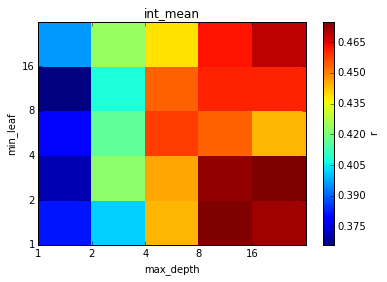

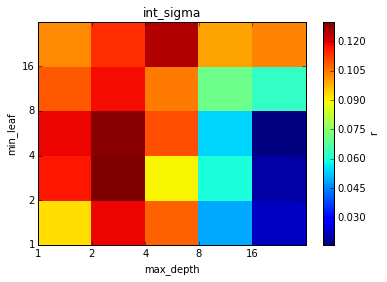

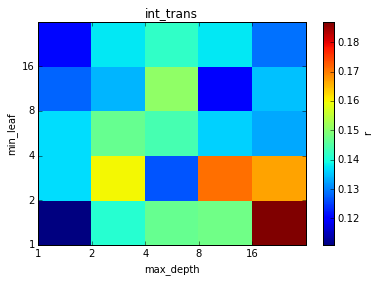

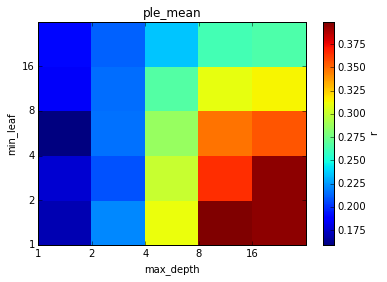

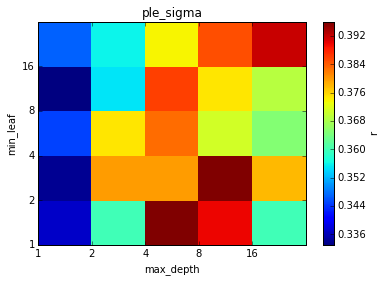

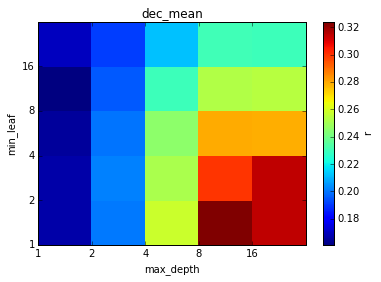

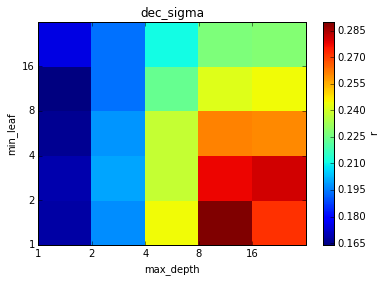

In [35]:
for kind in kinds:
    for moment in moments:
        if moment != 'trans' or kind == 'int':
            plt.figure()
            plt.xlabel('max_depth')
            plt.ylabel('min_leaf')
            plt.title('%s_%s' % (kind,moment))
            ax = plt.gca()
            ax.set_xticklabels([1,2,4,8,16])
            ax.set_yticklabels([1,2,4,8,16])
            plt.pcolor(rs_leaf_depth[kind][moment])
            plt.colorbar(label='r')

In [ ]:
"""
With rf:
For subchallenge 2, using cross-validation with:
        at most 1000 features:
        at least 1 samples per leaf:
        at most None depth:
        score = 4.65+/- 0.13
        int_mean = 0.417+/- 0.010
        ple_mean = 0.446+/- 0.014
        dec_mean = 0.302+/- 0.010
        int_sigma = -0.018+/- 0.014
        ple_sigma = 0.167+/- 0.014
        dec_sigma = 0.230+/- 0.007
        int_trans = 0.161+/- 0.011
        
With et:
For subchallenge 2, using cross-validation with:
        at most 1000 features:
        at least 1 samples per leaf:
        at most None depth:
        score = 4.87+/- 0.13
        int_mean = 0.594+/- 0.010
        ple_mean = 0.424+/- 0.017
        dec_mean = 0.294+/- 0.010
        int_sigma = 0.023+/- 0.020
        ple_sigma = 0.129+/- 0.014
        dec_sigma = 0.238+/- 0.008
        int_trans = 0.279+/- 0.012
